# VDJdb project
### Author: Renjie Zhou
Date: 2024.2.12

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Extract raw data and process
extract CDR3 $\beta$ and corrosponding epitope

In [3]:
def read_raw_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=0)
    return df
def get_clean_data(file_path):
    data_df = read_raw_data(file_path)
    cleaned_data = data_df.dropna(subset=['cdr3', 'antigen.epitope'])
    cleaned_data = data_df
    cleaned_data = cleaned_data[cleaned_data['complex.id'] != 0]
    cleaned_data = cleaned_data[cleaned_data['gene'] != 'TRB'] # delete alpha chain
    cleaned_data = cleaned_data[cleaned_data['species'] == 'HomoSapiens'] # reserve human species
    cleaned_data = cleaned_data[cleaned_data['vdjdb.score'] != 0] # delete score equals 0
    cleaned_data = cleaned_data[['cdr3', 'antigen.epitope']]
    cleaned_data.to_csv('epitope_cdr3_pair.csv',index=False)
    return cleaned_data

In [4]:
input_file_path = "vdjdb.txt"
data = get_clean_data(input_file_path)
data.head()
len(data)

2040

# Step 2: Data Visualisation

antigen.epitope
NLVPMVATV         461
GILGFVFTL         250
TFEYVSQPFLMDLE     87
GLCTLVAML          72
RPRGEVRFL          68
YLQPRTFLL          65
QYIKWPWYI          51
KLVALGINAV         40
ELAGIGILTV         23
SPRWYFYYL          22
Name: cdr3, dtype: int64


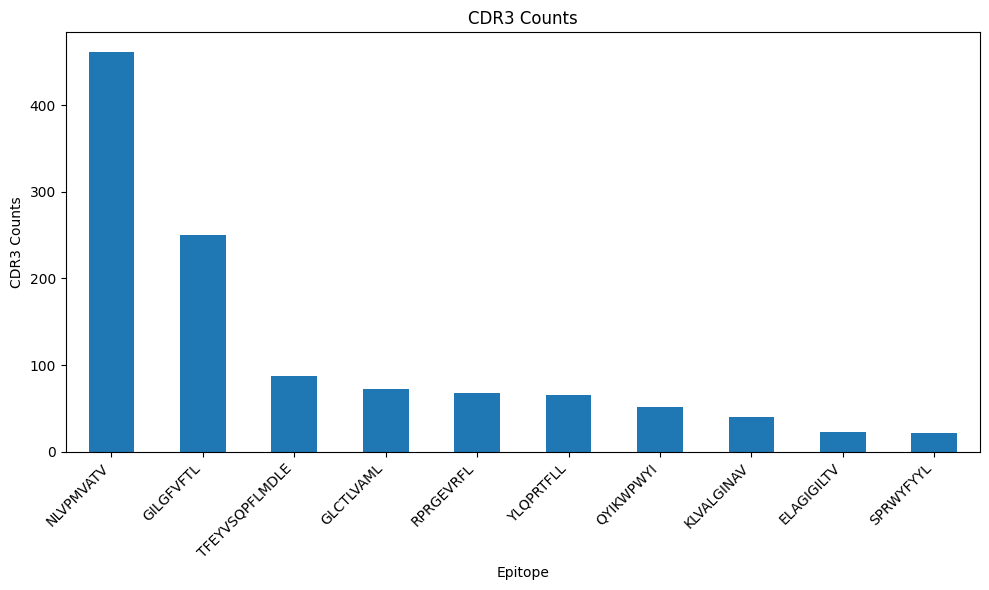

In [5]:

# 获得epitope计数
epitope_cdr3_counts = data.groupby('antigen.epitope')['cdr3'].count()
top_epitopes = epitope_cdr3_counts.sort_values(ascending=False).head(10)
print(top_epitopes)
# 创建柱状图
plt.figure(figsize=(10, 6))
top_epitopes.plot(kind='bar')
plt.title('CDR3 Counts')
plt.xlabel('Epitope')
plt.ylabel('CDR3 Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 显示图形
plt.show()

# Step 3: Finding a way to encode - kmer algorithm
k-mer, which is a widely used disambiguation technique in bioinformatics.
### 01. Create the splitCDR function for slicing the sequence according to a given k value.

In [6]:
# create epitope-(cdr3 group) dictionary
def convert_to_dic(data):
    epiDict = {}
    
    for index, row in data.iterrows():
        epitope = row['antigen.epitope']
        cdr3 = row['cdr3']

        if epitope not in epiDict:
            epiDict[epitope] = []

        epiDict[epitope].append(cdr3)

    return epiDict


In [7]:
def splitCDR(CDRseq, k = 3):
    retDict = [] # Create an array of cuts and save them according to k=3 cuts
    for i in range(len(CDRseq) - k + 1):
        retDict.append(CDRseq[i:i+k])
    return retDict

### 02.Calculate the frequency of occurrence of all possible k-mer in the given set of CDR3 sequences.
Create a kmerDict dictionary with key as the partition with k of 3 and value as the frequency of occurrence

In [9]:
def statisticsKmer(epiDict, k=3):
    kmerDict = {}
    for epi in epiDict:
        for i in range(len(epiDict[epi])):
            splitList = splitCDR(epiDict[epi][i],k)
            for split in splitList:
                if split not in kmerDict:
                    kmerDict[split] = 1
                else:
                    kmerDict[split] += 1
    return kmerDict
data_dict = convert_to_dic(data)
cdr3_kmer_Dict = statisticsKmer(data_dict,3)
print(cdr3_kmer_Dict)

2324


### 03. Feature engineering
according to the kmer dictionary, each cdr3 will be encoded.$\newline$
the dimension of cdr3 is the length of kmer dictionary

In [45]:
def buildFeatures(epiDict, kmerDict, k=3, return_kmers=False):
    counter = 0
    for epi in epiDict:
        counter += len(epiDict[epi]) # The counter records the number of CDR3s corresponding to each epitope in the current epiDict.
    retArr = np.zeros((counter, len(kmerDict))) # Generate a two-dimensional array of 0's with counter rows and kmer record columns

    kmerList = list(kmerDict.keys()) # Extract the key from the kmerlist
    retLabel = []
    iter = 0
    epinum = 0
    for epi in epiDict:
        for cdr in range(len(epiDict[epi])):
            splitlist = splitCDR(epiDict[epi][cdr], k)
            retLabel.append(epinum) # Numbering records for the epitope corresponding to cdr3
            i = 0
            for kmer in kmerList: # Iterate over all possible kmer
                retArr[iter][i] = splitlist.count(kmer)
                i += 1
            iter += 1 
        epinum += 1 

    if not return_kmers:
        return np.array(retArr), np.array(retLabel)
    else:
        return np.array(retArr), np.array(retLabel), kmerList
    
retArr, retLabel = buildFeatures(data_dict, cdr3_kmer_Dict)

In [48]:
#np.savetxt("features.csv", retArr, delimiter=",")
#np.savetxt("labels.csv", retLabel, delimiter=",")
print(retArr)
print(retLabel)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[  0   0   0 ... 340 340 340]
